In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

Matrix and vector shapes:
A.shape: (3, 3)
B.shape: (3, 3)
q0.shape: (3, 1)
dq0.shape: (3, 1)
qT.shape: (3, 1)
dqT.shape: (3, 1)


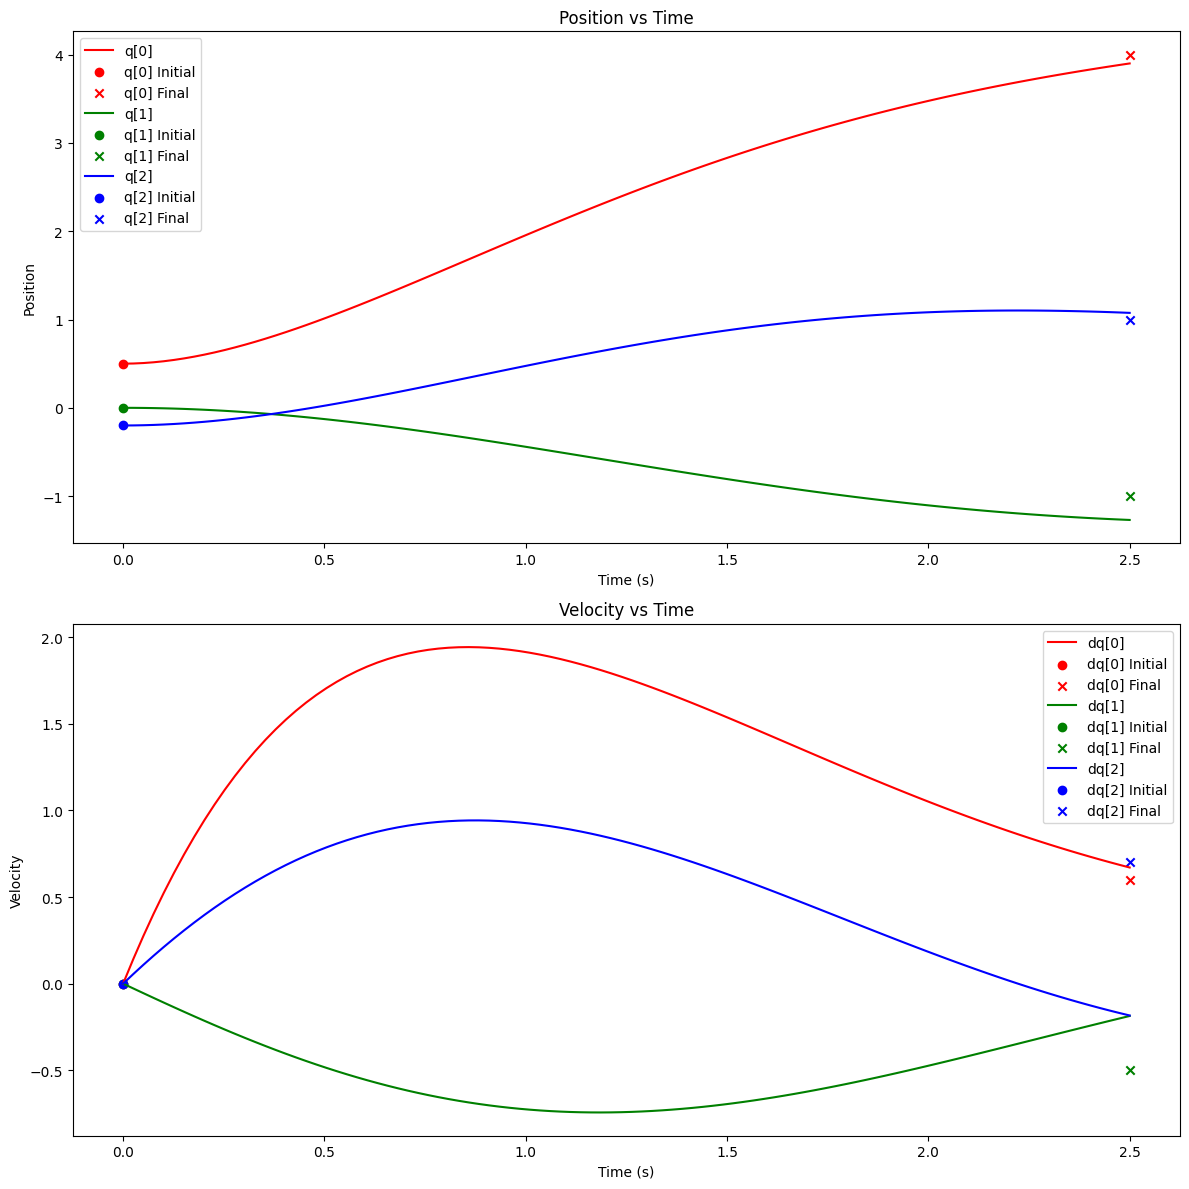

[[ 5.15160171]
 [-0.91197592]
 [ 0.90755879]]


0.9862630283908118

In [3]:
def solve_second_order_system(M, p, q0, dq0, t):
    """
    Solves the second-order system for given initial conditions and times.
    
    Args:
    - A_inv: Inverse of matrix A
    - M: Precomputed system matrix
    - p: Precomputed particular solution
    - q0: Initial position (vector)
    - dq0: Initial velocity (vector)
    - t: Time array (list or ndarray)
    
    Returns:
    - q: Array of positions at each time step
    - dq: Array of velocities at each time step
    """
    n = M.shape[0] // 2
    y0 = np.concatenate([q0, dq0])  # Initial condition as [q0, dq0]
    
    # Define the solution at time t
    def solution(t):
        return expm(M * t) @ (y0 - p) + p

    # Compute q and dq over time
    y = np.array([solution(ti).flatten() for ti in t])
    q = y[:, :n]
    dq = y[:, n:]
    return q, dq

def find_C(A, B, q0, dq0, qT, dqT, T, w=1.):
    """
    Finds the optimal C so that the error at time T is minimized.

    Args:
    - A: Matrix A of the system
    - B: Matrix B of the system
    - q0: Initial position
    - dq0: Initial velocity
    - qT: Target position at final time T
    - dqT: Target velocity at final time T
    - T: Final time
    
    Returns:
    - C_optimal: Optimal constant vector C
    """
    n = A.shape[0]
    A_inv = np.linalg.inv(A)
    
    # Precompute the system matrix M
    M = np.block([
        [np.zeros((n, n)), np.eye(n)],
        [-A_inv, -A_inv @ B]
    ])

    yT = np.concatenate([qT, dqT])  # Initial condition as [q0, dq0]
    y0 = np.concatenate([q0, dq0])  # Initial condition as [q0, dq0]

    eM_T = expm(M * T)
    M_2 = yT - eM_T @ y0
    M_1 = np.eye(2*n) - eM_T
    W_vect = np.ones(2*n)
    W_vect[n:] = w
    W = np.diag(W_vect)
    C_opt = (W * np.linalg.inv(M_1) @ M_2)[:n]
    
    return C_opt

def find_C_and_solve(A, B, q0, dq0, qT, dqT, T, t, w=1.):
    """
    Finds the optimal C and solves the second-order system.

    Args:
    - A: Matrix A of the system
    - B: Matrix B of the system
    - q0: Initial position
    - dq0: Initial velocity
    - qT: Target position at final time T
    - dqT: Target velocity at final time T
    - T: Final time
    - t: Array of time points to solve for
    - w: Weight for velocity in the objective function
    
    Returns:
    - C_optimal: Optimal constant vector C
    - q: Positions at each time step
    - dq: Velocities at each time step
    """
    n = A.shape[0]
    C_opt = find_C(A, B, q0, dq0, qT, dqT, T, w=w)
    
    p = np.block([
        [C_opt],
        [np.zeros((n, 1))]
    ])
    
    A_inv = np.linalg.inv(A)
    
    # Precompute the system matrix M
    M = np.block([
        [np.zeros((n, n)), np.eye(n)],
        [-A_inv, -A_inv @ B]
    ])
    
    q, dq = solve_second_order_system(M, p, q0, dq0, t)
    
    return C_opt, q, dq

# Plotting the results
def plot_trajectory(t, q_cp, dq_cp, q0, qT, dq0, dqT):
    COLORS = ['r', 'g', 'b']
    fig, axs = plt.subplots(2, 1, figsize=(12, 12))
    n = min(q_cp.shape[-1], 3)
    # Plot for position
    for i in range(n):
        axs[0].plot(t, q_cp[:, i], color=COLORS[i], label=f'q[{i}]')
        axs[0].scatter(t[0], q0[i], color=COLORS[i], marker='o', label=f'q[{i}] Initial')
        axs[0].scatter(t[-1], qT[i], color=COLORS[i], marker='x', label=f'q[{i}] Final')
    axs[0].set_title('Position vs Time')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Position')
    axs[0].legend()

    # Plot for velocity
    for i in range(n):
        axs[1].plot(t, dq_cp[:, i], color=COLORS[i], label=f'dq[{i}]')
        axs[1].scatter(t[0], dq0[i], color=COLORS[i], marker='o', label=f'dq[{i}] Initial')
        axs[1].scatter(t[-1], dqT[i], color=COLORS[i], marker='x', label=f'dq[{i}] Final')
    axs[1].set_title('Velocity vs Time')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Velocity')
    axs[1].legend()

    # Combine into a single plot
    plt.tight_layout()
    plt.show()


# Example system with 3 dimensions (n = 3)
n = 3  # System dimension
A = np.array([[1, 1.01, 0], [0.02, 1, 0.03], [0, 1.02, 1]])
B = np.array([[2., 0.2, 0.1], [0.1, 1., 0.3], [0.05, 0.2, 1.]])
q0 = np.array([[0.5], [0], [-0.2]])  # Initial position (3D)
dq0 = np.array([[0], [0], [0]])      # Initial velocity (3D)
qT = np.array([[4], [-1], [1]])      # Desired final position (3D)
dqT = np.array([[0.6], [-0.5], [0.7]])  # Desired final velocity (3D)
T = 2.5  # Final time
W = 10.  # Tradeoff between position and velocity
t = np.linspace(0, T, 100)  # Time array

print("Matrix and vector shapes:")
print("A.shape:", A.shape)
print("B.shape:", B.shape)
print("q0.shape:", q0.shape)
print("dq0.shape:", dq0.shape)
print("qT.shape:", qT.shape)
print("dqT.shape:", dqT.shape)

# Assuming find_C_and_solve function is already defined as in the earlier example.
C_optimal, q_cp, dq_cp = find_C_and_solve(A, B, q0, dq0, qT, dqT, T, t, w=W)
# C_optimal, q_cp, dq_cp = find_C_and_solve_old(A, B, q0, dq0, qT, dqT, T, t, w=W)

plot_trajectory(t, q_cp, dq_cp, q0, qT, dq0, dqT)

yT = np.concatenate([qT, dqT])  # Initial condition as [q0, dq0]
Y_cp_T = np.concatenate([q_cp[-1], dq_cp[-1]]).reshape(len(yT),1)  # Initial condition as [q0, dq0]

print(C_optimal)
np.linalg.norm(yT - Y_cp_T)